##### Imports

In [1]:
import sys
from pathlib import Path
import warnings

import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

import pickle
from pathlib import Path
from scr.dataset import *
from scr.game import *
from scr.plot_utils import *
import gc
from scr.utils import print_scenarios


from pathlib import Path
import random
from collections import Counter, defaultdict
import pickle
from tqdm import tqdm
from torch.utils.data import Dataset
from scr.feature_engineering import \
    calculate_char_frequencies, calculate_word_frequencies
from scr.utils import read_words, save_words_to_file

import sys
# Custom library paths
sys.path.extend(['../', './scr'])

from scr.utils import set_seed
from scr.utils import read_words

set_seed(42)

import torch
import torch.nn as nn
from pathlib import Path
import random

torch.set_float32_matmul_precision('medium')

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Read and Shuffle Word List
word_list = read_words('data/words_250000_train.txt') # , limit=10000)
# word_list = read_words('data/250k.txt', limit=10000)
random.shuffle(word_list)

##### Data reading and Params Settings

In [2]:
 #### Papermil if need
 
NUM_STRATIFIED_SAMPLES = 125000 # This will be overwritten by Papermill

In [3]:
base_dataset_dir = Path(f"/media/sayem/510B93E12554BBD1/dataset/{NUM_STRATIFIED_SAMPLES}")


print("NUM_STRATIFIED_SAMPLES:", NUM_STRATIFIED_SAMPLES)
print("base_dataset_dir:", base_dataset_dir)

# Import necessary library
from pathlib import Path

# # Validate if parameters are provided
# if NUM_STRATIFIED_SAMPLES is None or base_dataset_dir is None:
#     raise ValueError("NUM_STRATIFIED_SAMPLES and base_dataset_dir must be provided.")

# Define the base directory on the specified drive
base_dataset_dir = Path(base_dataset_dir)

# Ensuring the directory exists
base_dataset_dir.mkdir(parents=True, exist_ok=True)

# Create a subdirectory for pickle files
pkls_dir = base_dataset_dir / 'pkl'
pkls_dir.mkdir(parents=True, exist_ok=True)

NUM_STRATIFIED_SAMPLES: 125000
base_dataset_dir: /media/sayem/510B93E12554BBD1/dataset/125000


In [4]:
# Splitting Dataset Function
import random

def split_dataset(word_list, train_ratio=0.8):
    total_words = len(word_list)
    train_size = int(total_words * train_ratio)
    random.shuffle(word_list)
    return word_list[:train_size], word_list[train_size:]

# Splitting the word list
train_words, test_words = split_dataset(word_list)

# Save split datasets to files
save_words_to_file(train_words, base_dataset_dir / 'train_words.txt')
save_words_to_file(test_words, base_dataset_dir / 'test_words.txt')

# Calculate Frequencies and Max Word Length
word_frequencies = calculate_word_frequencies(train_words)
char_frequency = calculate_char_frequencies(train_words)
max_word_length = max(len(word) for word in train_words)

In [5]:
len(train_words)

181840

##### Stratified Sample Generation

In [6]:
## we are taking starified samples from train_words

from scr.custom_sampler import \
    stratified_sample_by_length_and_frequency, \
        stratified_sample_by_length, stratified_sample_by_length_and_uniqueness

print(f'Number of Statrified samples: {NUM_STRATIFIED_SAMPLES}')

# sampled_words_by_length_and_frequency \
#     = stratified_sample_by_length_and_frequency(train_words, \
#     word_frequencies, \
#     NUM_STRATIFIED_SAMPLES)

Number of Statrified samples: 125000


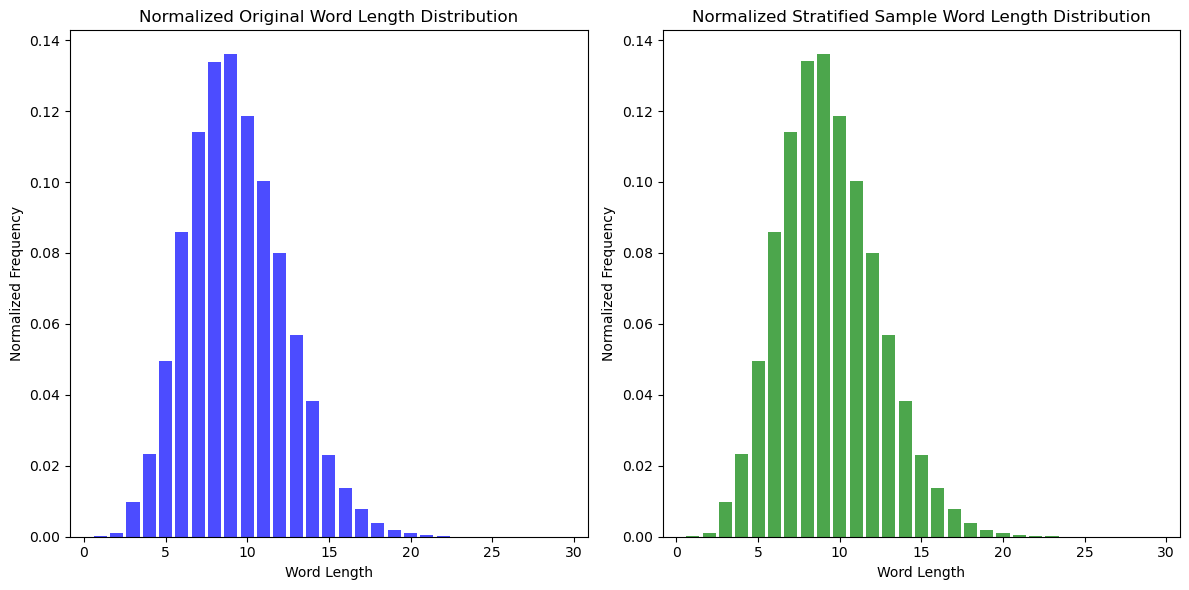

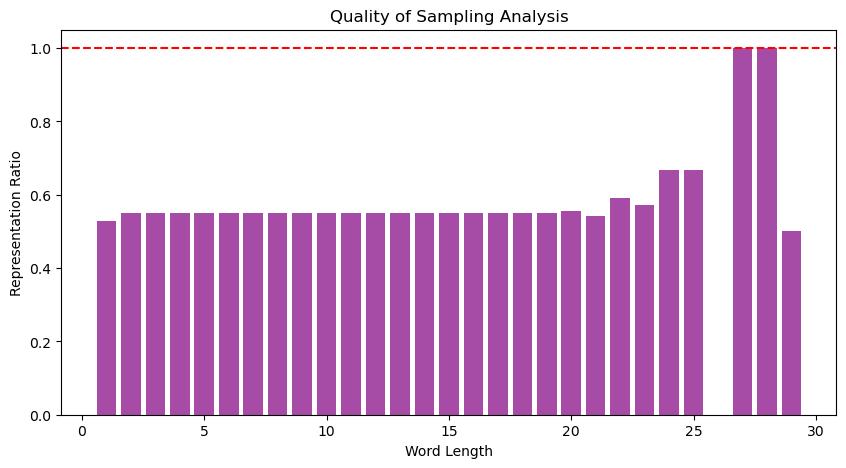

In [7]:
from scr.plot_utils import analyze_hangman_sample_practicality

representation_evaluation, unique_inclusion = analyze_hangman_sample_practicality(
    word_list, 
    stratified_sample_by_length_and_uniqueness, 
    NUM_STRATIFIED_SAMPLES
)


sampled_words_by_length = stratified_sample_by_length_and_uniqueness(word_list, \
    NUM_STRATIFIED_SAMPLES)

In [8]:
# sampled_words_by_length_and_frequency \
#     = stratified_sample_by_length_and_frequency(train_words, \
#     word_frequencies, \
#     NUM_STRATIFIED_SAMPLES)

##### Intial State Simulation Testing

In [9]:
# word = "mississippi"
word = "mythopoetize"
# word = "cat"

initial_states = process_word_for_six_states(word)

initial_states

{'allMasked': '____________',
 'early': '__t_____t___',
 'quarterRevealed': '__th____t___',
 'midRevealed': '_yth___et__e',
 'midLateRevealed': 'mytho_oet__e',
 'lateRevealed': 'mythopoet_ze',
 'nearEnd': 'mythopoet_ze'}

In [10]:
from scr.game import simulate_game_progress, play_game_with_a_word, process_word

# Example word and initial state
# Example usage
word = "mississippi"
# word = "cat"

initial_states = process_word_for_six_states(word)

# print(initial_states)
# Print generated initial states
print("Generated Initial States:")
for state_name, initial_state in initial_states.items():
    # Simulate the game
    print(initial_state)
    print(f"For initial state: {initial_state}")
    won, game_progress = simulate_game_progress(
        model=None,  # Assuming model is not used in this example
        word=word, 
        initial_state=initial_state, 
        char_frequency={},  # Assuming char_frequency is not used in this example
        max_word_length=len(word), 
        device=None,  # Assuming device is not used in this example
        max_attempts=6, 
        normalize=True,
        difficulty="medium", 
        outcome_preference='win'
    )

    # Display game progress
    for step in game_progress:
        print(f"Guessed: '{step[0]}', New State: '{step[1]}', Correct: {step[2]}")

        # break

    # break

    # print("Game Result:", "Won" if won else "Lost")

Generated Initial States:
___________
For initial state: ___________
Guessed: 'e', New State: '___________', Correct: False
Guessed: 'x', New State: '___________', Correct: False
Guessed: 'm', New State: 'm__________', Correct: True
Guessed: 's', New State: 'm_ss_ss____', Correct: True
Guessed: 'b', New State: 'm_ss_ss____', Correct: False
Guessed: 'p', New State: 'm_ss_ss_pp_', Correct: True
Guessed: 'u', New State: 'm_ss_ss_pp_', Correct: False
Guessed: 'z', New State: 'm_ss_ss_pp_', Correct: False
Guessed: 'i', New State: 'mississippi', Correct: True
__ss_ss____
For initial state: __ss_ss____
Guessed: 'v', New State: '__ss_ss____', Correct: False
Guessed: 'g', New State: '__ss_ss____', Correct: False
Guessed: 't', New State: '__ss_ss____', Correct: False
Guessed: 'j', New State: '__ss_ss____', Correct: False
Guessed: 'p', New State: '__ss_ss_pp_', Correct: True
Guessed: 'e', New State: '__ss_ss_pp_', Correct: False
Guessed: 'b', New State: '__ss_ss_pp_', Correct: False
__ss_ss____
F

In [11]:
len(initial_states)

7

In [12]:
initial_states

{'allMasked': '___________',
 'early': '__ss_ss____',
 'quarterRevealed': '__ss_ss____',
 'midRevealed': '__ss_ss_pp_',
 'midLateRevealed': '_ississippi',
 'lateRevealed': '_ississippi',
 'nearEnd': '_ississippi'}

##### Dataset Generation: Simulation

In [ ]:
word = "mississippi"

initial_states = process_word_for_six_states(word)
# print(initial_states)
# Print generated initial states
print("Generated Initial States: ", initial_states)

In [ ]:
# ### one way to generate the dataset
iteration = 0 
for word in tqdm(sampled_words_by_length, miniters=2, leave=False, mininterval=2.0): 
    
    all_scenarios = []
    
    game_states = process_word_for_six_states(word)

    for state_name, initial_state in game_states.items():
        for difficulty in ["easy", "medium", "hard"]:
            for outcome in ["win", "lose"]:
                won, game_progress = simulate_game_progress(
                    model=None, 
                    word=word, 
                    initial_state=initial_state, 
                    char_frequency=char_frequency, 
                    max_word_length=max_word_length, 
                    device=device, 
                    max_attempts=6, 
                    normalize=True, 
                    difficulty=difficulty, 
                    outcome_preference=outcome
                )

                scenario = {
                    'word': word,
                    'state': state_name,  # Added 'state' key
                    'difficulty': difficulty,
                    'outcome': outcome, 
                    'initial_state': initial_state,
                    'data': (won, game_progress),
                    'word_length': len(word)
                }
                all_scenarios.append(scenario)

    #             break
    #         break
    #     break
    # break

    # Create a directory for the current strarified samples
    
    current_batch_dir = pkls_dir / str(iteration)
    current_batch_dir.mkdir(parents=True, exist_ok=True)

    # print(all_scenarios)

    # print(current_batch_dir)

    for scenario in all_scenarios:
        try:
            game_states = [scenario['data']]
            
            difficulty = scenario['difficulty']
            outcome = scenario['outcome']
            state = scenario['state']
            initial_state = scenario['initial_state']  # This should be the correct scope
            word_len = scenario['word_length']
            file_path \
                = current_batch_dir \
                    / f"{word}-from-{initial_state}-{state}-{difficulty}-{outcome}-{word_len}.pkl"

            # print(f"Saving scenario for {word}: {file_path}")

            with open(file_path, 'wb') as file:
                pickle.dump(game_states, file)

            # print(f"Saved {file_path}")

        except Exception as e:
            print(f"Error saving {file_path}: {e}")

    # Clear memory
    del all_scenarios # , sampled_scenarios

    # Manual garbage collection
    gc.collect()

    # train_words = [word for word in train_words if word not in sampled_words]
    # print(len(train_words))
    # print(iteration)
    iteration += 1

In [ ]:
pkls_dir

##### Reading Checking

In [ ]:
import pickle
from pathlib import Path

pkl_list = []

for batch_dir in sorted(pkls_dir.iterdir(), \
    key=lambda x: int(x.name) if x.name.isdigit() else float('inf')):

    if batch_dir.is_dir():
        pkl_files = list(batch_dir.glob("*.pkl"))

        for pkl_file in pkl_files:
            with open(pkl_file, 'rb') as file:
                game_data = pickle.load(file)

                parts = pkl_file.stem.split('-from-')
                word, remaining = parts[0], parts[1]
                remaining_parts = remaining.split('-')
                initial_state = remaining_parts[0]
                state_name = remaining_parts[1]
                difficulty = remaining_parts[2]
                outcome = remaining_parts[3]
                word_len = remaining_parts[4]

                for data in game_data:
                    game_won, guesses = data
                    scenario = {
                        'word': word,
                        'state': state_name,
                        'difficulty': difficulty,
                        'outcome': outcome,
                        'initial_state': initial_state,
                        'data': (game_won, guesses),
                        'word_length' : word_len

                    }
                    pkl_list.append((pkl_file, scenario))

# Example usage
index_to_access = 1000
if index_to_access < len(pkl_list):
    file_path, scenario = pkl_list[index_to_access]
    print(f"Contents of {file_path}:")
    # Assuming print_scenarios is a defined function
    print_scenarios([scenario])
else:
    print(f"No pickle file at index {index_to_access}")
